## Car Price Prediction using Linear, Ridge and Lasso Regression

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation


### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [310]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [311]:
# reading the dataset
house = pd.read_csv("train.csv")

# summary of the dataset: 1460 rows, 80 columns, no null values, 
#as per analysis of the dataset, NA means it not applicable, but in actual it is not NULL as interpreted by info() below
print(house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [276]:
# head
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attributes; some non-obvious ones are:

In [277]:
# MSSubClass:dwelling involved in the sale
# Most cars are 0,1,2
house['MSSubClass'].astype('category').value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [278]:
# MSZoning: Identifies the general zoning classification of the sale.

house['MSZoning'].astype('category').value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [279]:
# LotShape: General shape of property 
house['LotShape'].astype('category').value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [280]:
# LandContour: General shape of property 
house['LandContour'].astype('category').value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [281]:
# Utilities: Type of utilities available 
house['Utilities'].astype('category').value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [282]:
# Neighborhood: Physical locations within Ames city limits
house['Neighborhood'].astype('category').value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [283]:
# OverallQual: Rates the overall material and finish of the house
house['OverallQual'].astype('category').value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

In [284]:
# OverallCond: Rates the overall condition of the house
house['OverallCond'].astype('category').value_counts()

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

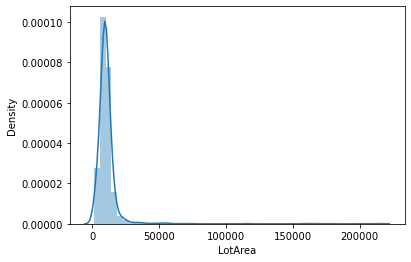

In [285]:
# LotArea: Lot size in square feet
sns.distplot(house['LotArea'])
plt.show()

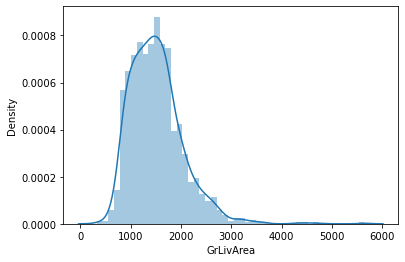

In [286]:
# GrLivArea: Above grade (ground) living area square feet
sns.distplot(house['GrLivArea'])
plt.show()

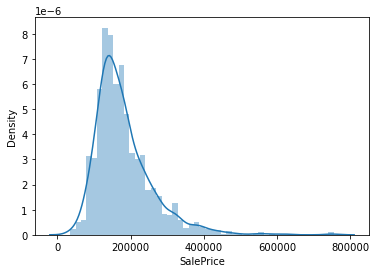

In [287]:
# target variable: price of car
sns.distplot(house['SalePrice'])
plt.show()

#### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.


We'll first subset the list of all (independent) numeric variables, and then make a **pairwise plot**.

In [288]:
# all numeric (float and int) variables in the dataset
house_numeric = house.select_dtypes(include=['float64', 'int64'])
house_numeric.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


Here, although the variable 'MSSubClass' is numeric (int), we'd rather treat it as categorical since they have categorial values

In [289]:
# dropping MSSubClass, Id
house_numeric = house_numeric.drop(['Id','MSSubClass'], axis=1)
house_numeric.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,61,0,0,0,0,0,2,2008,208500
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,298,0,0,0,0,0,0,5,2007,181500
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,42,0,0,0,0,0,9,2008,223500
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,0,35,272,0,0,0,0,2,2006,140000
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,192,84,0,0,0,0,0,12,2008,250000


This is quite hard to read, and we can rather plot correlations between variables. Also, a heatmap is pretty useful to visualise multiple correlations in one plot.

In [290]:
# correlation matrix
corr1 = house_numeric.corr()
corr1

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
LotFrontage,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,-0.209294,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378
BsmtUnfSF,0.132644,-0.002618,0.308159,-0.136841,0.149040,0.181133,0.114442,-0.495251,-0.209294,1.000000,...,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258,0.214479


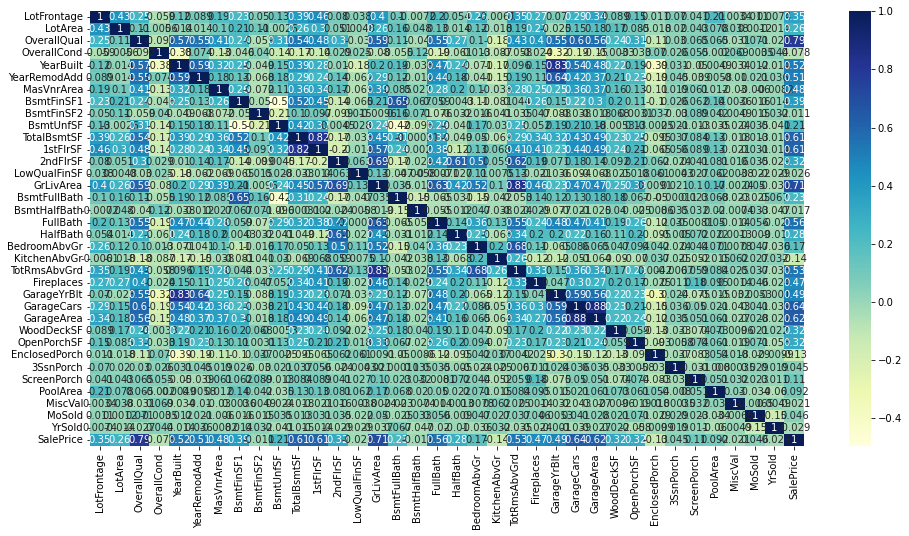

In [291]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(corr1, cmap="YlGnBu", annot=True)
plt.show()


The heatmap shows some useful insights:

Correlation of SalesPrice with independent variables:
- Price is highly (positively) correlated with GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, 

- Price is negatively correlated to EnclosedPorch, ScreKitchenAbvGrenPorch, MiscVal etc


Thus, while building the model, we'll have to pay attention to multicollinearity (especially linear models, such as linear and logistic regression, suffer more from multicollinearity).

## 2. Data Cleaning

Let's now conduct some data cleaning steps. 

We've seen that there are no missing values in the dataset. We've also seen that variables are in the correct format, except ```MSSubClass, OverallQual, OverallCond, MoSold```, which should rather be a categorical variable (so that dummy variable are created for the categories).

Note that it *can* be used in the model as a numeric variable also. 



In [124]:
# variable formats
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [125]:
# outliers
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [312]:
#impute NA values of GarageYrBlt with median
median_GarageYrBlt=np.median(house[~house["GarageYrBlt"].isnull()]["GarageYrBlt"])
house["GarageYrBlt"].fillna(median_GarageYrBlt,inplace=True)

In [313]:
#impute NA values of GarageYrBlt with median
medMasVnrArea=np.median(house[~house["MasVnrArea"].isnull()]["MasVnrArea"])
house["MasVnrArea"].fillna(medMasVnrArea,inplace=True)


In [314]:
#impute NA values of GarageYrBlt with median
medLotFrontage=np.median(house[~house["LotFrontage"].isnull()]["LotFrontage"])
house["LotFrontage"].fillna(medLotFrontage,inplace=True)


## 3. Data Preparation 


#### Data Preparation

Let's now prepare the data and build the model.

In [315]:
# split into X and y

house = house.drop(['Id','MoSold','YrSold','YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'], axis=1)
#house = house.drop(['Id'], axis=1)
y = house.pop('SalePrice')
X = house


In [316]:
# creating dummy variables for categorical variables

# subset all categorical variables
house_categorical = X.select_dtypes(include=['object'])
house_categorical.head()


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [317]:
# convert into dummies - one hot encoding
house_dummies = pd.get_dummies(house_categorical, drop_first=True)
house_dummies.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [318]:
# drop categorical variables 
X = X.drop(list(house_categorical.columns), axis=1)

In [319]:
# concat dummy variables with X
X = pd.concat([X, house_dummies], axis=1)

In [320]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 240 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(2), int64(29), uint8(209)
memory usage: 651.7 KB


In [321]:
# scaling the features - necessary before using Ridge or Lasso
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
house_int = X.select_dtypes(include=['int64'])
num_vars = house_int.columns
X[num_vars] = scaler.fit_transform(X[num_vars])

house_float = X.select_dtypes(include=['float64'])
num_vars1 = house_float.columns
X[num_vars1] = scaler.fit_transform(X[num_vars1])

In [304]:
num_vars

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [305]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.235294,0.150685,0.033420,0.666667,0.500,0.12250,0.125089,0.0,0.064212,0.140098,...,0,0,0,0,1,0,0,0,1,0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.00000,0.173281,0.0,0.121575,0.206547,...,0,0,0,0,1,0,0,0,1,0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.10125,0.086109,0.0,0.185788,0.150573,...,0,0,0,0,1,0,0,0,1,0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.00000,0.038271,0.0,0.231164,0.123732,...,0,0,0,0,1,0,0,0,0,0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.21875,0.116052,0.0,0.209760,0.187398,...,0,0,0,0,1,0,0,0,1,0


In [322]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## 3. Model Building and Evaluation

## Linear Regression

Let's now try predicting house prices, a dataset using linear regression.

In [323]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)


LinearRegression()

In [324]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

4577728440848553.0
[-1.04899322e+04  1.66342686e+04  1.28780470e+05  6.30620639e+04
  4.11035681e+04  3.55800238e+04  1.69657399e+17  4.43081158e+16
  7.02196462e+16 -1.83665256e+17  1.95594567e+17  9.26807668e+16
  2.56723480e+16 -2.38232208e+17  5.99600000e+03 -3.20200000e+03
  7.79362500e+03 -1.04600000e+03 -2.18520000e+04 -5.51400000e+04
 -5.99400000e+03  3.18800000e+03  2.31520000e+04  1.16240000e+04
  8.01500000e+03  1.02780000e+04 -1.30050000e+04  1.22398750e+04
  4.93900000e+03  1.27489000e+05  9.75000000e+03  2.76680000e+04
  2.90000000e+04  2.62420000e+04  2.21670000e+04  2.48375000e+04
 -2.32200000e+03  2.89375000e+02  2.80515625e+03  1.20800000e+03
  2.46400000e+03 -7.35600000e+03  4.24000000e+03 -1.64915000e+04
  9.33600000e+03 -8.38500000e+03  2.53600000e+03 -3.60000000e+02
  3.71100000e+03 -2.61252500e+04  1.03127500e+04  1.68800000e+03
 -1.89800000e+03 -3.58900000e+03 -5.20000000e+02  1.90390000e+04
 -1.21860000e+04  1.09000000e+03 -2.40000000e+03 -8.13400000e+03
 -1.31

In [325]:
from sklearn.metrics import r2_score, mean_squared_error

In [326]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9474903890587252
-1.3577578227470151e+22
335048011494.0
3.82712898815818e+34
328156720.36630756
8.737737415886256e+31


## Ridge and Lasso Regression

Let's now try predicting car prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

## Ridge Regression

In [327]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [329]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.1}


In [349]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised
alpha = 0.2
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-1.42250110e+04  4.75373650e+03  8.36381373e+04  6.77397847e+04
  3.62847029e+04  3.40585468e+04  8.17986900e+04  2.12488909e+04
  1.40604341e+04  8.60618405e+04  1.05182920e+05  9.90973741e+04
 -9.35561669e+03  1.23902002e+05  1.51860125e+04  9.59564203e+02
  1.35755061e+04 -6.92954394e+02 -1.56825214e+04 -3.96076559e+04
  3.33990235e+03  1.02670043e+04  3.42149892e+04  2.42119323e+03
  8.17799512e+03  8.35316925e+03 -7.27976106e+03  1.50563724e+04
  7.07842163e+03  6.20591364e+04  4.32391224e+03  2.39246280e+04
  2.59419469e+04  2.49743728e+04  2.20054562e+04  1.64153620e+04
 -2.99618390e+03  8.78091974e+02 -3.28809768e+03  1.23451781e+03
  8.18927032e+03  2.42292681e+03  9.49062566e+03 -2.21215475e+04
  1.03822993e+04 -1.03278094e+04 -2.88424759e+03 -1.58352685e+03
  4.94268522e+03 -4.92753899e+03  3.05733412e+03  1.75579045e+03
 -3.03488301e+03 -2.54002705e+03 -2.06441946e+02  2.08836218e+04
 -1.52960981e+04  2.75129182e+02 -4.61200690e+03 -7.45500300e+03
 -1.44464192e+04 -9.84022

In [350]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9417199608764268
0.7382621468392935
371867375669.25977
737763766371.0756
364218781.26274216
1684392160.664556


## Lasso

In [333]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [334]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 50}


In [351]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =100

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=100)

In [352]:
lasso.coef_

array([-2.33873962e+04,  0.00000000e+00,  2.67383832e+04,  8.79493754e+04,
        3.33604590e+04,  2.16503084e+04,  2.65214202e+04,  0.00000000e+00,
       -0.00000000e+00,  9.48390938e+04,  0.00000000e+00,  2.22700211e+04,
       -1.41412584e+04,  2.46457561e+05,  2.02005522e+04,  0.00000000e+00,
        1.15226757e+04,  2.69594618e+03, -0.00000000e+00, -1.19454471e+04,
        0.00000000e+00,  1.00873247e+04,  2.74696511e+04,  8.77534051e+03,
        7.89088766e+03,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.77444541e+03, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  3.51414938e+02,  0.00000000e+00, -0.00000000e+00,
        2.59014026e+03,  2.55944328e+03,  5.03780749e+03, -0.00000000e+00,
        9.93427797e+03, -4.56660980e+03, -0.00000000e+00, -3.75500367e+02,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  

In [353]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9232480896282547
0.739383586657399
489730822366.56714
734602749903.7477
479658004.2767553
1677175228.090748


In [354]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.474904e-01,9.417200e-01,9.232481e-01
1,R2 Score (Test),-1.357758e+22,7.382621e-01,7.393836e-01
2,RSS (Train),3.350480e+11,3.718674e+11,4.897308e+11
3,RSS (Test),3.827129e+34,7.377638e+11,7.346027e+11
4,MSE (Train),1.811510e+04,1.908452e+04,2.190110e+04
5,MSE (Test),9.347587e+15,4.104135e+04,4.095333e+04


## Lets observe the changes in the coefficients after regularization

In [355]:
betas = pd.DataFrame(index=X.columns)

In [356]:
betas.rows = X.columns

In [357]:
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [358]:
pd.set_option('display.max_rows', None)
betas.head(68)

,Linear,Ridge,Lasso
MSSubClass,-1.048993e+04,-14225.010975,-23387.396211
LotFrontage,1.663427e+04,4753.736496,0.000000
LotArea,1.287805e+05,83638.137316,26738.383242
OverallQual,6.306206e+04,67739.784670,87949.375368
OverallCond,4.110357e+04,36284.702949,33360.459011
MasVnrArea,3.558002e+04,34058.546790,21650.308403
BsmtFinSF1,1.696574e+17,81798.690017,26521.420221
BsmtFinSF2,4.430812e+16,21248.890922,0.000000
BsmtUnfSF,7.021965e+16,14060.434100,-0.000000
TotalBsmtSF,-1.836653e+17,86061.840545,94839.093822


In [359]:
ridge_sorted = pd.DataFrame(index=X.columns)
ridge_sorted['Ridge'] = ridge.coef_
ridge_sorted.rows = X.columns

ridge_sorted = ridge_sorted.sort_values(by="Ridge", ascending=False)

In [360]:
ridge_sorted

,Ridge
GrLivArea,123902.002420
RoofMatl_WdShngl,119879.387761
1stFlrSF,105182.919690
2ndFlrSF,99097.374132
TotalBsmtSF,86061.840545
LotArea,83638.137316
BsmtFinSF1,81798.690017
RoofMatl_Membran,68373.814317
OverallQual,67739.784670
PoolArea,62059.136369


In [361]:
Lasso_sorted = pd.DataFrame(index=X.columns)
Lasso_sorted['Lasso'] = lasso.coef_
Lasso_sorted.rows = X.columns

Lasso_sorted = Lasso_sorted.sort_values(by="Lasso", ascending=False)
Lasso_sorted

,Lasso
GrLivArea,246457.560576
TotalBsmtSF,94839.093822
OverallQual,87949.375368
RoofMatl_WdShngl,52319.198464
Neighborhood_NoRidge,40062.401537
OverallCond,33360.459011
GarageCars,27469.651057
LotArea,26738.383242
BsmtFinSF1,26521.420221
Neighborhood_NridgHt,22626.121528
